In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from deepMacroFin import PDEModel
from deepMacroFin import Comparator, EndogVar, EndogVarConditions, EndogEquation

## Model 1 Diffusion 1D
$$\frac{\partial y}{\partial t} = \frac{\partial^2 y}{\partial x^2} - e^{-t} (\sin(\pi x) - \pi^2 \sin (\pi x))$$
with $x\in [-1,1], t\in[0,1]$, $y(x,0)=\sin(\pi x)$, $y(-1,t)=y(1,t)=0$.

Solution: $y=e^{-t}\sin(\pi x)$

In [2]:
pde1 = PDEModel("diffusion_1d")
pde1.set_state(["x", "t"], {"x": [-1., 1.], "t": [0, 1.]})
pde1.add_endog("y")
pde1.add_endog_equation("y_t = y_xx - exp(-t) * (sin(pi * x) - pi**2 * sin(pi*x))", label="base_pde")

mone_xs = -1 * torch.ones((100, 2))
mone_xs[:, 1] = torch.Tensor(np.linspace(0, 1, 100))

one_xs = torch.ones((100, 2))
one_xs[:, 1] = torch.Tensor(np.linspace(0, 1, 100))

zero_ts = torch.zeros((100, 2))
zero_ts[:, 0] = torch.Tensor(np.linspace(-1, 1, 100))
y_zero_ts = torch.sin(torch.pi * zero_ts[:, 0:1])

pde1.add_endog_condition("y", 
                              "y(SV)", {"SV": mone_xs},
                              Comparator.EQ,
                              "0", {},
                              label="bc_zerox")
pde1.add_endog_condition("y", 
                              "y(SV)", {"SV": one_xs},
                              Comparator.EQ,
                              "0", {},
                              label="bc_onex")
pde1.add_endog_condition("y", 
                              "y(SV)", {"SV": zero_ts},
                              Comparator.EQ,
                              "y_zero_ts", {"y_zero_ts": y_zero_ts},
                              label="ic")

print(pde1)
if not os.path.exists("./models/diffusion_1d.pt"):
    pde1.train_model("./models", "diffusion_1d.pt", True)
else:
    pde1.load_model(torch.load("./models/diffusion_1d.pt"))
    pde1.eval_model(True)

=========================Summary of Model diffusion_1d==========================
Config: {
 "batch_size": 100,
 "num_epochs": 1000,
 "lr": 0.001
}
Latex Variable Mapping: {}

================================State Variables=================================
x: [-1.0, 1.0]
t: [0, 1.0]

=====================================Agents=====================================

================================Agent Conditions================================

==============================Endogenous Variables==============================
Endogenous Variable Name: y
EndogVar(
  (model): Sequential(
    (linear_0): Linear(in_features=2, out_features=30, bias=True)
    (activation_0): Tanh()
    (linear_1): Linear(in_features=30, out_features=30, bias=True)
    (activation_1): Tanh()
    (linear_2): Linear(in_features=30, out_features=30, bias=True)
    (activation_2): Tanh()
    (linear_3): Linear(in_features=30, out_features=30, bias=True)
    (activation_3): Tanh()
    (final_layer): Linear(in_featur

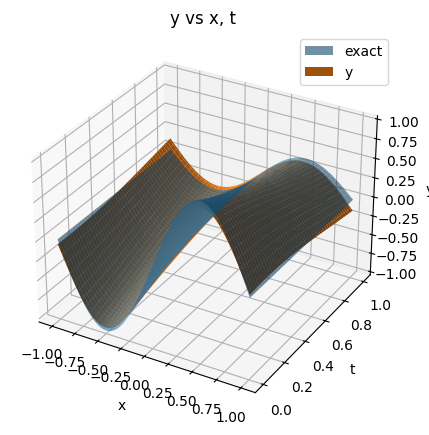

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), subplot_kw={"projection": "3d"})
x_np = np.linspace(-1, 1, 100)
t_np = np.linspace(0, 1, 100)
X, T = np.meshgrid(x_np, t_np)
exact_Y = np.exp(-T) * np.sin(np.pi*X)
ax.plot_surface(X, T, exact_Y, label="exact", alpha=0.6)
pde1.endog_vars["y"].plot("y", {"x": [-1., 1.], "t": [0, 1.]}, ax=ax)
plt.subplots_adjust()
plt.show()